This notebook contains all of the functions necessary for analyzing the stability numerically with a reasonable parameter range for both the full function and the Hill function approximation.

1. Bifurcation diagram 

In [1]:
# Setup
import analysisfunctions as af
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

# Fixed parameters
# Beetle productivity
c = 500
# Fixed values of k and phi
k=10;p=200;
# Fixed value of s
s=0.99;
# m range
mr = np.linspace(0,c,num=1000)

# Colors
c1 = '#00485C' # This is the official dark blue
c2 = '#0084A8' # Official light blue
c3 = '#986532' # Official "yellow", which is more dark brown.
cg = '0.4' # Grey
# Other options:
#'#F2E2CA' # Pale straw yellow 
#'#986532' # Darker brown
# And generate an array of lightness values, from 5% to 95% lightness including the official one which is 18%.
# 20 colors, and index 16 is the initial one
# Useful link: https://www.w3schools.com/colors/colors_picker.asp
c_arr = [ '#e6f9ff','#ccf4ff','#b3eeff','#99e9ff','#80e3ff','#66deff','#4dd8ff','#33d3ff','#1acdff','#00c8ff',
          '#00b4e6','#00a0cc','#008cb3','#007899','#006480','#005066','#00485c','#003c4d','#002833','#00141a']

# 1. Bifurcation diagram

In [2]:
# Set range of threshold phi to investigate
pr_bif = np.arange(c)+1 # Make the smallest threshold 1

# Because the optimum n is different for each threshold, we can either take the n directly from the fixed k and p as
n = af.get_hill_n(k,p,c)
# Or we can find the distribution of n across all thresholds for p
# This is kind of slow, so only run it if we want to use it.
# If we do this, we find the median is 4.89 and the mean is 5.0, which is very comparable to the default of 4.87.
#narr = np.array([get_hill_n(k,p,c,nmax=50) for p in pr])
#print(np.median(narr), narr.mean()) # The median is 4.89 and the mean is 5.0

In [3]:
# Get the values of m against phi for the bifurcation plots

# Find the critical point for m and p
ms_hill = c*(n-1)/n
peq_hill = (n-1)**((n-1)/n)/n*c
# Given (n-1)/n ~ 0.8, we should see outbreaks for gamma < 0.80*c, or ~400

# Numerically we have to find the critical point for the full function with varying p
peq_sol = opt.root(lambda x: af.fdf_eq(x[0],c,k,x[1]),x0=[300,300])
ms_full,peq_full = peq_sol.x
# Numerically ms_hill and ms_full should be similar.

# Now for each pr, solve for m. Solve for bottom and top root and ignore m=0, since that is always a solution
mhill = np.zeros((len(pr_bif),2))
mfull = np.zeros((len(pr_bif),2))

# Define an epsilon away from 0 for bracketing.
me = 0.0001

for i,pp in enumerate(pr_bif):
    # Check for first root.
    # m/c always starts positive, so if this is less than 0 at the midpoint, 
    # then there is an additional root and if not, then we leave it at 0.
    if ms_hill/c - 1 + af.fhill(ms_hill,n,pp) < 0:
        # Bracket the first room from epsilon to the critical value
        mhill[i,0] = opt.root_scalar(lambda x: x/c - 1 + af.fhill(x,n,pp),bracket=[me,ms_hill]).root
        # If we have first root we also have second, above the critical value (except exactly at m*)
        mhill[i,1] = opt.root_scalar(lambda x: x/c - 1 + af.fhill(x,n,pp),bracket=[ms_hill,c]).root
    # Now for the full function
    if ms_full/c - 1 + af.ffull(ms_full,k,pp) < 0:
        mfull[i,0] = opt.root_scalar(lambda x: x/c - 1 + af.ffull(x,k,pp),bracket=[me,ms_full]).root
        mfull[i,1] = opt.root_scalar(lambda x: x/c - 1 + af.ffull(x,k,pp),bracket=[ms_full,c]).root

In [4]:
# Check to make sur ethat the above code snippet worked and print out some information

# Save phi where things are first non-zero for upper and middle branches
phi_hill = [mhill[:,0]==0,mhill[:,1]==0]
phi_full = [mfull[:,0]==0,mfull[:,1]==0]

# Save indices of first non zero occurance.
phi_i = []
for phi in [phi_hill,phi_full]:
    if np.nonzero(phi[0])[0][0]==np.nonzero(phi[1])[0][0]:
        phi_i.append(np.nonzero(phi[0])[0][0])
    else:
        # If we are here in the code there could be an error in how we calculated zeros above, 
        # as the zeros aren't appearing in the same place
        print("Non zero in different spots! This could be an error.")
        phi_i.append([np.nonzero(phi[0])[0][0],np.nonzero(phi[1])[0][0]])
    
# Get values of phi for each case
phi_val = [pr_bif[i] for i in phi_i]
print("Values of phi where we no longer have the two non-trivial solutions")
print("Hill function, and then Full function, with k={:.0f}, n={:.1f}".format(k,n))
print(phi_val)
print("Compare with expected outbreaks from approximations at")
print("m* = {:.2f}, phi* = {:.2f}".format(ms_hill,peq_hill))
print("And compare with numerical solution earlier for the full function at")
print("m* = {:.2f}, phi* = {:.2f}".format(ms_full,peq_full))

Values of phi where we no longer have the two non-trivial solutions
Hill function, and then Full function, with k=10, n=4.9
[301, 290]
Compare with expected outbreaks from approximations at
m* = 397.23, phi* = 300.86
And compare with numerical solution earlier for the full function at
m* = 398.23, phi* = 289.73


In [5]:
# Now calculate the spectral radius everywhere
spec_full = np.zeros((len(pr_bif),3))
spec_hill = np.zeros((len(pr_bif),3))

for spec,mr,kk,f,df in zip([spec_full,spec_hill],[mfull,mhill],[k,n],[af.ffull,af.fhill],[af.dffull,af.dfhill]):
    for i,p in enumerate(pr_bif):
        spec[i,0] = af.specrad(0,s,c,f,df,kk,p)
        spec[i,1] = af.specrad(mr[i,0],s,c,f,df,kk,p)
        spec[i,2] = af.specrad(mr[i,1],s,c,f,df,kk,p)
        
# Now turn these into indices for stability
stableargs_full = spec_full<1
stableargs_hill = spec_hill<1

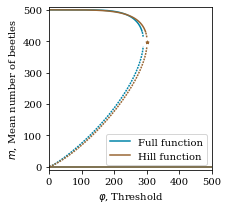

In [6]:
# Now plot
fig,ax = plt.subplots(1,1,figsize=(3,3))

# For each branch, plot stable points using solid lines and unstable using dashed
for args, m, cc, lb in zip([stableargs_full,stableargs_hill],[mfull,mhill],
                           [c2,c3],['Full function','Hill function']):
    # For zero branch, assume it works, and don't plot if it doesn't
    if np.all(args[:,0]):
        ax.plot(pr_bif,np.zeros(len(pr_bif)),c=cc,ls='-',label=lb)
    # For the other branches, plot according to stability, and only if m > 0
    for i in np.arange(2):
        args2 = m[:,i]>0
        ids = args[:,i+1]&args2
        ids2 = (~args[:,i+1])&args2
        ax.plot(pr_bif[ids],m[ids,i],c=cc,ls='-')
        ax.plot(pr_bif[ids2],m[ids2,i],c=cc,ls='--',dashes=(1.2, 0.7))

# Plot expected outbreak point
ax.scatter(peq_hill,ms_hill,c=c3,s=10,marker='*')

# Fix up axes, labels etc.
ax.set_xlim(0,c)
ax.set_ylim(-10,510)
ax.set_xlabel(r'$\varphi$, Threshold')
ax.set_ylabel(r'$m$, Mean number of beetles')
ax.set_box_aspect(1)
ax.legend()

fig.savefig('figures/bifurcation_plot.pdf',bbox_inches='tight')